#Multi-Label Image Classification

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import re
import pandas as pd
from io import StringIO
from PIL import Image 
import os
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from zipfile import ZipFile

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

## Read Data

In [ ]:
%%time 
path = '/content/gdrive/My Drive/COMP5329'
file_name = '2020s1comp5329assignment2.zip'

with ZipFile(path + '/' + file_name, 'r') as z:
   # Extract all the contents of zip file in current directory
   z.extractall()

CPU times: user 10.9 s, sys: 3.72 s, total: 14.6 s
Wall time: 47.3 s


In [ ]:
file_names = []
path = os.getcwd() + "/COMP5329S1A2Dataset/data"
for file_name in os.listdir(path):
    file_names.append(file_name)
print(len(file_names)) #there should be 40,000 images 

40000


In [ ]:
def read_csv(file_name):

    with open(file_name) as file:
        lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
        df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

    return df

In [ ]:
df_train = read_csv(os.getcwd() + '/COMP5329S1A2Dataset/train.csv') #30,000 for training 
df_test = read_csv(os.getcwd() + '/COMP5329S1A2Dataset/test.csv') #10,000 for testing 

In [ ]:
print(df_train.shape) 
print(df_test.shape)
df_train.tail()

(29996, 3)
(10000, 2)


,ImageID,Labels,Caption
29991,29995.jpg,8 1 2,A picture of a truck that is in the middle of ...
29992,29996.jpg,1,A plate topped with a pizza being cut with a s...
29993,29997.jpg,1,A man riding a snowboard on top of snow.
29994,29998.jpg,1,This photo shows people skiing in the mountains.
29995,29999.jpg,1,Two young men playing soccer and fighting for ...


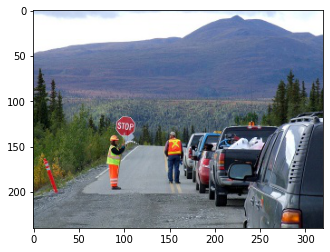

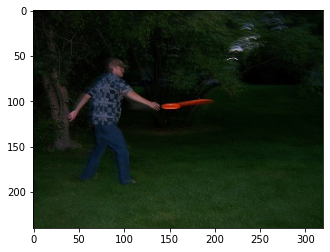

In [ ]:
### plot some images 
img1 = Image.open(path + '/' + file_names[0])
plt.imshow(img1) 
plt.show() 

img2 = Image.open(path + '/'+ file_names[1])
plt.imshow(img2) 
plt.show() 

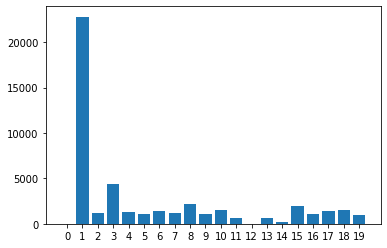

In [ ]:
### checking out class distribution 
labels_list = [0] * 20
for x in df_train['Labels'].tolist(): 
    labels = x.split() 
    for label in labels:
        labels_list[int(label)] += 1

plt.bar(np.arange(len(labels_list)), labels_list)
plt.xticks(np.arange(0, 20, 1.0))
plt.show()

### Pre-process captions

In [ ]:
%%time
### load pre-trained word embeddings
import gensim.downloader as api
word_emb_model = api.load("glove-twitter-25")

[==================================================] 100.0% 104.8/104.8MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


CPU times: user 48.7 s, sys: 2.34 s, total: 51 s
Wall time: 59.1 s


In [ ]:
def clean_captions(df, max_len):
    """
    Function to clean the captions and add padding.
    """
    cleaned_captions = []

    for caption in df['Caption'].tolist():

        caption = re.sub(r"[^a-z]+", " ", caption.lower())
        tokens = caption.split(' ') #split by white space 

        diff = max_len - len(tokens)

        if diff > 0: 
            for x in range(diff): 
                tokens.append('<PAD>')
        else: 
            tokens = tokens[0:max_len]
        cleaned_captions.append(' '.join(tokens))

    df['Caption'] = cleaned_captions

    return df

maximum caption length:  51
proportion of captions less than 15 in length: 0.9513701370137013


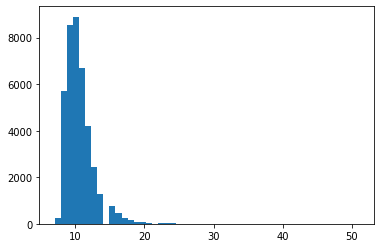

In [ ]:
### checking distribution of caption lengths 
caption_lengths = []
for caption in df_train['Caption'].tolist() + df_test['Caption'].tolist():
    caption_lengths.append(len(caption.split(' ')))
print('maximum caption length: ', max(caption_lengths))
short_captions = [x for x in caption_lengths if x < 15]
print('proportion of captions less than 15 in length:', len(short_captions)/len(caption_lengths))
plt.hist(caption_lengths, bins = 50)
plt.show() 

In [ ]:
%%time 
MAX_LENGTH = 15
df_train = clean_captions(df_train, MAX_LENGTH)
df_test = clean_captions(df_test, MAX_LENGTH)
df_train.head()

CPU times: user 194 ms, sys: 788 µs, total: 195 ms
Wall time: 196 ms


In [ ]:
### create dictionary containing word as key and associated number id 
word_to_idx = {}
for caption in df_train['Caption'].tolist() + df_test['Caption'].tolist():
    tokens = caption.split(' ')
    for word in tokens:
        if word not in word_to_idx:
            word_to_idx[word] = len(word_to_idx)

word_list = list(word_to_idx.keys())
vocab_size = len(word_list)
print('The number of unique words is: ', vocab_size)

The number of unique words is:  7902


In [ ]:
### create weight matrix with the GloVe embeddings to intialise weights for nn.Embedding layer
EMBEDDING_DIM = 25

embedding_matrix = []
for word in word_list:
    try:
        embedding_matrix.append(word_emb_model[word])
    except:
        embedding_matrix.append([0]*EMBEDDING_DIM)
embedding_matrix = np.array(embedding_matrix)
embedding_matrix.shape

(7902, 25)

### Custom Data Loader

In [ ]:
### divide train into training set and validation set. 
from sklearn.utils import shuffle
df_train = shuffle(df_train) #shuffle data before splitting 

df_valid = df_train[24000:]
df_train = df_train[0:24000]
print(df_valid.shape)
print(df_train.shape)

(5996, 3)
(24000, 3)


In [ ]:
# data augmentation methods for the training set.
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.Resize((224, 224)),#resize to 256 x 256 image 
    transforms.RandomCrop(224), #randomly crop to 224 x 224 image 
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0),
    transforms.ToTensor(), #load images to have range [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
# during validation we use only to tensor and normalization transforms
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
def prepare_caption_embedding(caption):
    """
    Function to convert the provided caption to a list 
    containing integers where each integer matches with a word. 
    """
    tokens = caption.split(' ')
    caption_idxs = []

    for token in tokens: 
        caption_idxs.append(word_to_idx[token])

    caption_idxs = np.array(caption_idxs)

    return torch.from_numpy(caption_idxs).type(torch.LongTensor)

In [ ]:
class CustomDataLoader(Dataset):
    def __init__(self, dataframe, folder_dir, transform = None, use_caption = False, use_test = False): 

        self.dataframe = dataframe
        self.folder_dir = folder_dir
        self.transform = transform 
        self.file_names = dataframe['ImageID'].tolist()
        self.captions = dataframe['Caption'].tolist()
        self.use_caption = use_caption
        self.use_test = use_test

        if self.use_test == False: 
            self.labels = dataframe['Labels'].tolist()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx): 
        image = Image.open(self.folder_dir + '/' + self.file_names[idx])
        
        if self.transform: 
            image = self.transform(image)

        sample = { 'img': image, 'img_name': self.file_names[idx]} 

        if self.use_test == False: 
            labels_vector = [0] * 18 #there are 10 classes 
            for label in self.labels[idx].split():
                if (int(label) < 12):
                    labels_vector[int(label)-1] = 1 #1 means the image has this label. 
                else:
                    labels_vector[int(label)-2] = 1
            sample['labels'] = torch.FloatTensor(labels_vector)

        if self.use_caption == True: 
            caption_embs = prepare_caption_embedding(self.captions[idx])
            sample['caption'] = caption_embs
            
        return sample

In [ ]:
path = os.getcwd() + "/COMP5329S1A2Dataset/data" #where all the images are stored 

### create data loaders 
train_dl = CustomDataLoader(df_train, path, transform = train_transform, use_caption = True)
valid_dl = CustomDataLoader(df_valid, path, transform = valid_transform, use_caption = True)
test_dl = CustomDataLoader(df_test, path, transform = valid_transform, use_caption = True, use_test = True)

train_dataloader = torch.utils.data.DataLoader(train_dl, shuffle = False, batch_size = 128)
valid_dataloader = torch.utils.data.DataLoader(valid_dl, shuffle = True, batch_size = 128)
test_dataloader = torch.utils.data.DataLoader(test_dl, shuffle = False, batch_size = 128)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The labels for this image: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
The caption for this image: tensor([ 11,  46, 177,  68,  40, 161, 124,  45, 125,   9,  10,  10,  10,  10,
         10])


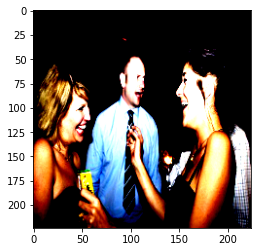

In [ ]:
### check the images loaded properly 
index = 0
plt.imshow(torchvision.utils.make_grid(train_dl[index]['img']).permute(1, 2, 0))

### check the labels
print('The labels for this image:', train_dl[index]['labels'])

### check the caption 
print('The caption for this image:', train_dl[index]['caption'])

## Models

### AlexNet

In [ ]:
model = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
#modify the fully connected layer
modules = [module for module in model.classifier]
modules.append(nn.ReLU(inplace = True))
modules.append(nn.Linear(1000, 20))
sequential = nn.Sequential(*modules)
model.classifier = sequential #replace the dense layers 
print(model)

### GoogleNet

In [ ]:
def create_fc_layer(num_features, num_classes, dropout_prob=0.4, activation_func = nn.ReLU):
  """
  This function is used to replace the last fully connected layer in the pre-trained 
  GoogleNet and ResNet50 model. 
  """
  features_list = [num_features , num_features//2]
  layers = []

  for in_f, out_f in zip(features_list[:-1] , features_list[1:]):
    layers.append(nn.Linear(in_f , out_f))
    layers.append(activation_func())
    layers.append(nn.BatchNorm1d(out_f))
    if dropout_prob != 0 : layers.append(nn.Dropout(dropout_prob))

  layers.append(nn.Linear(features_list[-1] , num_classes))

  return nn.Sequential(*layers)

In [ ]:
model = models.googlenet(pretrained=True) # load the pretrained model

### freeze the entire convolution base
for param in model.parameters():
  param.requires_grad_(False)

model.fc = create_fc_layer(model.fc.in_features, 18) #there are 18 classes 
model

### ResNet50

In [ ]:
model = models.resnet50(pretrained=True) # load the pretrained model

### freeze the entire convolution base
for param in model.parameters():
  param.requires_grad_(False)

### unfreeze the last 2 layers
for name, child in model.named_children():
   if name in ['layer2', 'layer3','layer4']:
       print(name + ' is unfrozen')
       for param in child.parameters():
           param.requires_grad = True
   else:
       print(name + ' is frozen')
       for param in child.parameters():
           param.requires_grad = False

### replace fully connected layer 
model.fc = create_fc_layer(model.fc.in_features, 18) #there are 18 classes 
model

conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is unfrozen
layer3 is unfrozen
layer4 is unfrozen
avgpool is frozen
fc is frozen


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Multi-input Model

In [ ]:
class MultiInputModel(nn.Module):
    def __init__(self):
        super(MultiInputModel, self).__init__()

        self.cnn = models.resnet50(pretrained=True) 

        ### unfreeze the last 2 layers
        for param in self.cnn.parameters(): 
            param.requires_grad = False

        for name, child in self.cnn.named_children():
            if name in ['layer3','layer4']:
                for param in child.parameters():
                    param.requires_grad = True

        self.word_embeds = nn.Embedding(vocab_size, EMBEDDING_DIM)
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))  
        self.lstm1 = nn.LSTM(25, 64, num_layers = 2, batch_first = True, bidirectional = True) # (word embedding size, hidden layer) 

        self.DenseLayers = nn.Sequential(
            nn.Linear(1128, 512, bias=True),
            nn.ReLU(inplace = True),
            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p = 0.40),        
            nn.Linear(512, 18, bias = True),
        )

    def forward(self, image, caption):

        x1 = self.cnn(image) #output = 1000 #shape = (128, 1000)
        x2 = self.word_embeds(caption)
        x2, (h_n, c_n) = self.lstm1(x2) #output = 64
        #concatenate forward and backward state 
        hidden_out = torch.cat((h_n[0,:,:], h_n[1,:,:]), 1) 
        x = torch.cat((x1, hidden_out), dim=1) #shape = 1064
        x = self.DenseLayers(x)

        return x
        
model = MultiInputModel()

### Caption Input Model

In [ ]:
class CaptionInputModel(nn.Module):
    def __init__(self):
        super(CaptionInputModel, self).__init__()

        self.word_embeds = nn.Embedding(vocab_size, EMBEDDING_DIM)
        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix))  
        self.lstm = nn.LSTM(25, 256, num_layers = 3, batch_first = True, bidirectional = True) #(word embedding size, hidden layer) 

        self.DenseLayers = nn.Sequential(
            nn.Linear(512, 512, bias=True),
            nn.ReLU(inplace = True),
            nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Dropout(p = 0.20),       
            nn.Linear(512, 256, bias=True),            
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), 
            nn.Dropout(p = 0.20),  
            nn.Linear(256, 18, bias = True),
        )

    def forward(self, caption):

        x = self.word_embeds(caption)
        x, (h_n, c_n) = self.lstm(x) #output = 256
        hidden_out = torch.cat((h_n[0,:,:], h_n[1,:,:]), 1)
        x = self.DenseLayers(hidden_out)

        return x
        
model = CaptionInputModel()

## Train Model

In [ ]:
#model = torch.load('/content/gdrive/My Drive/COMP5329/model-10.pt')

In [ ]:
#define some global variables to store losses and accuracies 
train_losses, train_accs, valid_losses, valid_accs = [], [], [], []

In [ ]:
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print('We are using GPU.' if use_cuda else 'We are using CPU.')
torch.cuda.empty_cache() #empty any used memory

We are using GPU.


In [ ]:
criterion = nn.BCEWithLogitsLoss() #binary cross entropy loss 
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1.0, gamma=0.95)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score 
import datetime 

def train_epoch(model, epoch, save_path, dataloader, model_input = 'image', mode = 'train', save = False): 
    """
    Function to train each epoch. An epoch is completed when all the batches have
    been processed. 
    
    Parameters:
        model: the loaded model 
        epoch: the current epoch the training process is up to 
        save_path: string path for where you want to save the model 
        dataloader: pytorch's data loading utility for either the training or validation data
        model_input: string that can either be 'image', 'caption' or 'both'
        mode: string indicating whether in training or evaluation mode. 
        save: boolean value indicating whether to save the model so far or not. 
    """

    time1 = datetime.datetime.now()

    if mode == 'train': 
        model.train()
    else: #put model in validation mode 
        model.eval()
        
    #keep track of training and validation loss and accuracy 
    running_loss, running_acc = 0, 0 

    #mini-batch training with the dataloader 
    for batch_idx, data in enumerate(dataloader): 
        #move this batch of data to specified device 
        inputs = data['img'].to(device) #a tensor image
        captions = data['caption'].to(device)
        targets = data['labels'].to(device) #a tensor vector 

        with torch.set_grad_enabled(mode =="train"): 

            #forward the data through the model.
            if model_input == 'image': 
                output = model(inputs) 
            elif model_input == 'caption': 
                output = model(captions)
            elif model_input == 'both': 
                output = model(inputs, captions)

            loss = criterion(output, targets)  #calculate the loss
            predictions = torch.sigmoid(output).data > 0.50 #rounds each element in vector to nearest integer
            predictions = predictions.to('cpu').to(torch.int).numpy() #copy tensor to host memory
            targets = targets.to('cpu').to(torch.int).numpy()

            acc = f1_score(targets, predictions, average = 'micro')
            
            if mode == 'train': 
                loss.backward()  #backward the loss and calculate gradients for parameters.
                optimizer.step()  #update the parameters.
                optimizer.zero_grad() #zero the gradient to stop from accumulating
    
        running_loss += loss.item()
        running_acc += acc #mean accuracy of all examples in batch 
        
    time2 = datetime.datetime.now()

    epoch_loss = running_loss/len(dataloader) #len(dataloader) = no. of examples / batch size 
    epoch_acc = running_acc/len(dataloader) #mean accuracy of all batches

    if save == True:  
        torch.save(model, save_path + '/model-{}.pt'.format(epoch+1))

    return epoch_loss, epoch_acc, (time2-time1).total_seconds()

In [ ]:
def train_model(epochs, model, save_path, train_dataloader, valid_dataloader, model_input = 'image'): 
    """
    Function to train the model.
    
    Parameters:
        epoch: number of epochs to train model for 
        model: the loaded model 
        save_path: string path for where you want to save the model 
        train_dataloader: pytorch's data loading utility for training data 
        valid_dataloader: pytorch's data loading utility for the validation data
        model_input: string that can either be 'image', 'caption' or 'both'. 
    """
    for epoch in range(0, epochs): 

        save_status = False 

        if (epoch + 1) % 5 == 0: #save the model every 5 epochs 
            save_status = True 

        train_loss, train_acc, runtime = train_epoch(model, epoch + 1, save_path, train_dataloader, 
                                                     model_input, mode = 'train', save = save_status)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        print("Epoch:%d, train loss: %.2f, train acc: %.4f, time: %.2fs" %(epoch+1, train_loss, train_acc, runtime))
        
        if (epoch + 1) % 5 == 0: #every 5 epochs, run on validation set. 
            valid_loss, valid_acc, runtime = train_epoch(model, epoch + 1, save_path, valid_dataloader, 
                                                         model_input, mode = 'validate', save = False)
            
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

            print('-----------------------------------------------------------')
            print("Epoch:%d, valid loss: %.2f, valid acc: %.4f, time: %.2fs" %(epoch+1, valid_loss, valid_acc, runtime))
            print('-----------------------------------------------------------')

        scheduler.step() #apply learning rate scheduling after every epoch 

In [ ]:
save_path = '/content/gdrive/My Drive/COMP5329' #change the save path here. 
model_input = 'image' #can either be 'image', 'caption' or 'both'. 
losses, accuracies = train_model(10, model, save_path, train_dataloader, valid_dataloader, model_input)

## Kaggle Predictions

In [ ]:
def predictions_to_labels(predictions): 
    """
    Converts the encoded predictions to the original label format.
    """
    final_predictions = []
    for pred in predictions: 
        
        labels = list(np.where(pred == 1)[0])
        final_labels = []

        for label in labels: 
            if label < 12:
                final_labels.append(str(label+1))
            else:
                final_labels.append(str(label+2))
        final_predictions.append(' '.join(final_labels))

    return final_predictions 

In [ ]:
def get_predictions(model, dataloader): 
    """
    Get predictions for the test set using pre-trained model. 
    """
    model.eval() 

    image_names, test_predictions = [], []

    for batch_idx, data in enumerate(dataloader): 

        inputs = data['img'].to(device) #a tensor image
        image_names += data['img_name']
        output = model(inputs)  #forward the data through the model.
        predictions = torch.sigmoid(output).data > 0.50 #returns encoded predictions 
        predictions = predictions.to('cpu').to(torch.int).numpy() #copy tensor to host memory
        test_predictions += predictions_to_labels(predictions)

    return image_names, test_predictions 

In [ ]:
### load pre-trained model 
%%time 
model = torch.load('/content/gdrive/My Drive/COMP5329/model-10.pt')
model = model.to(device)
names, predictions = get_predictions(model, test_dataloader)

In [ ]:
### create submission file 
kaggle_submission = pd.DataFrame.from_dict({'ImageID': names, 'Labels': predictions})
kaggle_submission.to_csv('submission.csv', index = False)

In [ ]:
kaggle_submission.tail(200)

,ImageID,Labels
9800,39800.jpg,1 3
9801,39801.jpg,1 3 6
9802,39802.jpg,1 3 6
9803,39803.jpg,1
9804,39804.jpg,1
...,...,...
9995,39995.jpg,1
9996,39996.jpg,1 3 4
9997,39997.jpg,1
9998,39998.jpg,1


## Evaluation on Validation Set

In [ ]:
import sklearn.metrics as skm

In [ ]:
def evaluate_model(model, dataloader): 
    """
    Get predictions for the validation set using pre-trained model. 
    """
    model.eval() 

    labels, valid_predictions = [], []
    
    for batch_idx, data in enumerate(dataloader): 
        inputs = data['img'].to(device) #a tensor image
        labels += list(data['labels'].to(torch.int).numpy())

        output = model(inputs)  #forward the data through the model.
        predictions = torch.sigmoid(output).data > 0.50 #returns encoded predictions 
        predictions = predictions.to('cpu').to(torch.int).numpy() #copy tensor to host memory
        
        valid_predictions += list(predictions)

    return labels, valid_predictions 

In [ ]:
%%time 
y_true, y_pred = evaluate_model(model, valid_dataloader)

CPU times: user 26.3 s, sys: 3.89 s, total: 30.2 s
Wall time: 30.3 s


In [ ]:
 ### print classification report 
 cm = skm.multilabel_confusion_matrix(y_true, y_pred)
 print(skm.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      4557
           1       0.70      0.43      0.53       199
           2       0.64      0.67      0.66       801
           3       0.85      0.70      0.77       232
           4       0.95      0.88      0.91       223
           5       0.80      0.74      0.77       289
           6       0.92      0.82      0.87       238
           7       0.70      0.45      0.55       447
           8       0.87      0.69      0.77       200
           9       0.66      0.64      0.65       272
          10       0.92      0.59      0.72       119
          11       0.92      0.61      0.73       120
          12       0.96      0.57      0.72        47
          13       0.69      0.30      0.42       374
          14       0.82      0.54      0.65       200
          15       0.88      0.77      0.82       297
          16       0.90      0.47      0.62       337
          17       0.87    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
